In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt

import math

import cv2 as cv
import numpy as np

import os




Szczytowy stosunek sygnału do szumu, rzadziej stosunek sygnału szczytowego do szumu (PSNR, ang. peak signal-to-noise ratio) – stosunek maksymalnej mocy sygnału do mocy szumu zakłócającego ten sygnał. Ze względu na szeroki zakres wartości PSNR wyrażany jest w decybelach.

PSNR jest przybliżeniem ludzkiej percepcji jakości rekonstrukcji.

W przypadku braku szumu oba obrazy są identyczne, a zatem MSE wynosi zero. W tym przypadku PSNR jest nieskończony

In [ ]:
def psnr(target, ref):
         
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

https://arxiv.org/pdf/1501.00092.pdf

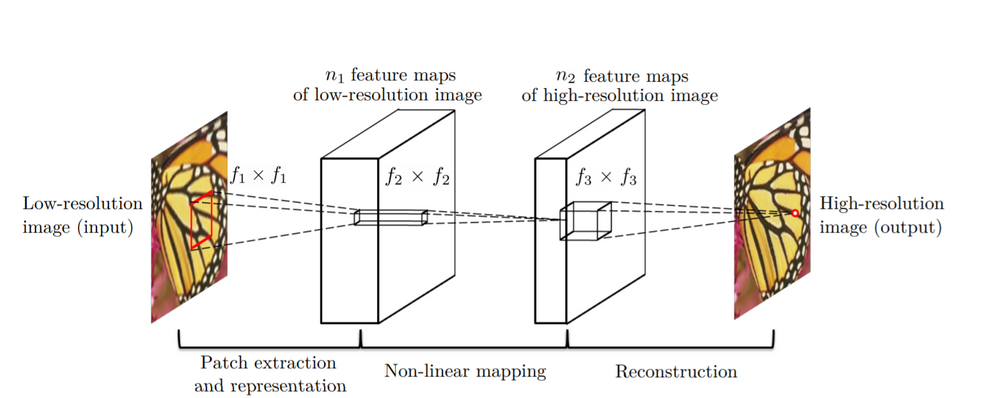

struktura sieci: 

warstwa pierwsza: operacja wyodrębnia część obrazu Y o niskiej rozdzielczości i przedstawia każdą łatkę jako
wektor wielowymiarowy. 

warstwa druga: operacja nieliniowa
mapuje każdy wysokowymiarowy wektor na inny
wektor wielowymiarowy. 

warstwa trzecia: rekonstrukcja, ta operacja agreguje łaty
aby wygenerować ostateczny obraz w wysokiej rozdzielczości.

In [ ]:
inputs = keras.Input(shape=(128, 128, 3), name='img')

x = layers.Conv2D(
    filters=64,             
    kernel_size=9,          
    padding='same',         
    activation=tf.nn.relu   
)(inputs)

x = layers.Conv2D(
    filters=32,      
    kernel_size=1,
    padding='same',  
    activation=tf.nn.relu
)(x)

outputs = layers.Conv2D(
    filters=3,
    kernel_size=5,          
    padding='same'          
)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='SRCNN_model')
  
model.summary() 

Model: "SRCNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      15616     
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      2080      
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 3)       2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


Test działania na zbiorze cifar-10

Obraz LR- startowy cifar-10 o obniżonej jakości interpolacja „najbliższego sąsiada” 

Obraz GT- startowy cifar-10 

In [ ]:
ishape = 128

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


train_image = train_images[0:5000]
test_image  = test_images[0:500]


X_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in test_image]) / 255.

y_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image]) / 255.

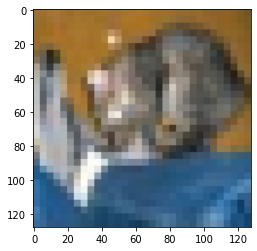

In [ ]:
plt.imshow(X_test[0])

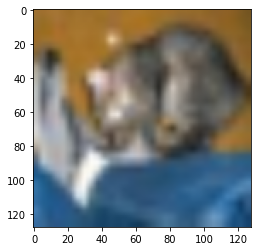

In [ ]:
plt.imshow(y_test[0])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       
              metrics=['mae'])    

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                    validation_split=0.2)

test_scores = model.evaluate(X_test, y_test, verbose=2) 

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

model.save('SRCNN.h5')

Epoch 1/3
63/63 [==============================] - 12s 179ms/step - loss: 0.7927 - mae: 0.2127 - val_loss: 0.0113 - val_mae: 0.0760
Epoch 2/3
63/63 [==============================] - 11s 170ms/step - loss: 0.0109 - mae: 0.0720 - val_loss: 0.0085 - val_mae: 0.0598
Epoch 3/3
63/63 [==============================] - 11s 169ms/step - loss: 0.0092 - mae: 0.0662 - val_loss: 0.0089 - val_mae: 0.0669
16/16 - 1s - loss: 0.0091 - mae: 0.0683 - 540ms/epoch - 34ms/step
Test loss: 0.009126700460910797
Test mae: 0.0683259591460228


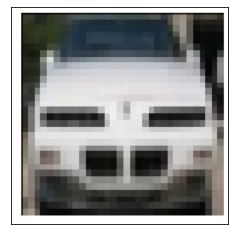

In [ ]:
ishape = 128

img = cv.imread('/content/drive/MyDrive/bmw.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()

Test na obrazie testowym

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


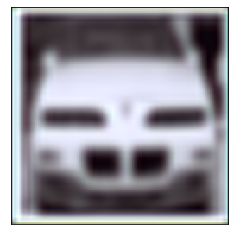

In [ ]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.


img_SR = model.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()

Obliczenie PSNR

In [ ]:
psnr(img,img_SR)

65.05051367824218

In [ ]:
#### RR ##################

Test działania na zbiorze pokemon (809 obrazów)

Obraz LR- obraz o jakości obniżonej blurem

Obraz GT- startowy obraz

In [ ]:
inputs = keras.Input(shape=(120, 120, 3), name='img')

x = layers.Conv2D(
    filters=64,             
    kernel_size=9,          
    padding='same',         
    activation=tf.nn.relu   
)(inputs)

x = layers.Conv2D(
    filters=32,      
    kernel_size=1,
    padding='same',  
    activation=tf.nn.relu
)(x)

outputs = layers.Conv2D(
    filters=3,
    kernel_size=5,          
    padding='same'          
)(x)

model2 = keras.Model(inputs=inputs, outputs=outputs, name='SRCNN_model')
  
model2.summary() 

Model: "SRCNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 64)      15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 3)       2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [ ]:
images = []


for file in os.listdir('/content/drive/MyDrive/images/'):
    images.append(cv.imread('/content/drive/MyDrive/images/{}'.format(file)))

In [ ]:
ishape = 120

train_image = images[0:647]
test_image  = images[647:]

train_image2 = images[0:647] #czyste
test_image2  = images[647:]



for i in range(np.asarray(647)):

  
  train_image[i] = cv.blur(train_image[i],(7,7))
 


for i in range(np.asarray(809-647)):

  
  test_image[i] = cv.blur(test_image[i],(7,7))
 

X_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image]) / 255.


y_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image2]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image2]) / 255.

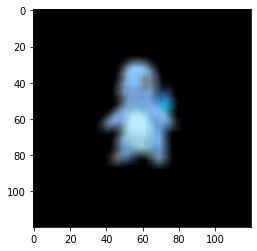

In [ ]:
plt.imshow(X_test[77])

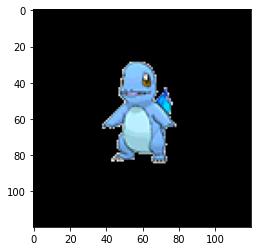

In [ ]:
plt.imshow(y_test[77])

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       
              metrics=['mae'])    

history = model2.fit(X_train, y_train,
                    batch_size=32,
                    epochs=30,
                    validation_split=0.2)

test_scores = model2.evaluate(X_test, y_test, verbose=2) 

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

model2.save('SRCNN_2.h5')

Epoch 1/30
17/17 [==============================] - 12s 113ms/step - loss: 0.3432 - mae: 0.1727 - val_loss: 0.0455 - val_mae: 0.1089
Epoch 2/30
17/17 [==============================] - 1s 81ms/step - loss: 0.0284 - mae: 0.0838 - val_loss: 0.0149 - val_mae: 0.0589
Epoch 3/30
17/17 [==============================] - 1s 79ms/step - loss: 0.0176 - mae: 0.0641 - val_loss: 0.0167 - val_mae: 0.0656
Epoch 4/30
17/17 [==============================] - 1s 78ms/step - loss: 0.0155 - mae: 0.0580 - val_loss: 0.0150 - val_mae: 0.0549
Epoch 5/30
17/17 [==============================] - 1s 79ms/step - loss: 0.0155 - mae: 0.0571 - val_loss: 0.0163 - val_mae: 0.0590
Epoch 6/30
17/17 [==============================] - 1s 78ms/step - loss: 0.0140 - mae: 0.0524 - val_loss: 0.0127 - val_mae: 0.0488
Epoch 7/30
17/17 [==============================] - 1s 78ms/step - loss: 0.0127 - mae: 0.0486 - val_loss: 0.0119 - val_mae: 0.0446
Epoch 8/30
17/17 [==============================] - 1s 79ms/step - loss: 0.0125 -

Test na obrazie testowym

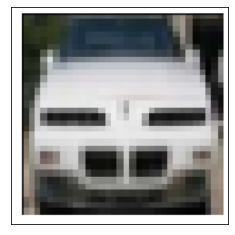

In [ ]:
ishape = 120

img = cv.imread('/content/drive/MyDrive/bmw.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


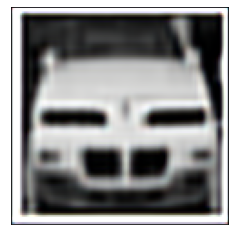

In [ ]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.

img_SR = model2.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()

Obliczenie PSNR

In [ ]:
psnr(img,img_SR)

65.28110895328332

Porównanie wizualne uzyskanych wyników (od góry: SR cifar, SR pokemon, LR test)


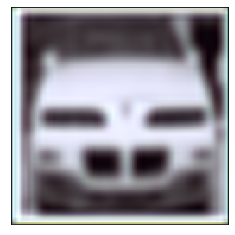

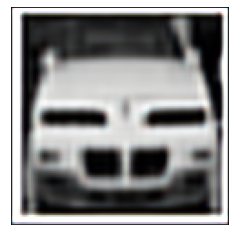
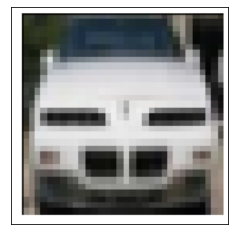

Wnioski:

1. Sieć SRCNN została zbudowana w prawidłowy sposób z wykorzystaniem artykułu twórców.

2. Czas nauki sieci jest krótki (80s dla obu sieci), w przypadku nauki na zbiorze cifar-10 sieć zużywa prawie 10GB Ramu, sieć pokemon 3GB.

3. Miara PSNR w dobry sposób odwzorowuje ludzki sposób precepcji jakości. SR pokemon jest wizualnie lepszej jakości od SR cifar 10. Warto rozważyć dodanie współczynnika SSIM w celu oceny jakość obrazów SR pod względem innych kryterium.


